In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('input_data/train_sampling5.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
8263536   15       1  22      245        2    10
5049031    3       1  41      280        1     1
         app  device  os  channel  weekday  hour
5029867   72       1  19      101        1    16
2028224    8       1  13      145        2    20
8263536    0
5049031    0
Name: is_attributed, dtype: int64
5029867    1
2028224    0
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None) #stddev=0.05

# structure of NN: 16 - 64 - 32 - 16 - sigmoid
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(8,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 10240
epoch = 10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}
# class_weight = {0:0.95, 1:0.05}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 7758144 samples, validate on 862016 samples
Epoch 1/10
7758144/7758144 [==============================] - 88s 11us/step - loss: 0.1281 - acc: 0.9223 - val_loss: 0.2051 - val_acc: 0.9363
Epoch 2/10
7758144/7758144 [==============================] - 91s 12us/step - loss: 0.0889 - acc: 0.9460 - val_loss: 0.2061 - val_acc: 0.9391
Epoch 3/10
7758144/7758144 [==============================] - 87s 11us/step - loss: 0.0841 - acc: 0.9500 - val_loss: 0.2073 - val_acc: 0.9393
Epoch 4/10
7758144/7758144 [==============================] - 90s 12us/step - loss: 0.0812 - acc: 0.9528 - val_loss: 0.1709 - val_acc: 0.9523
Epoch 5/10
7758144/7758144 [==============================] - 85s 11us/step - loss: 0.0796 - acc: 0.9542 - val_loss: 0.1889 - val_acc: 0.9399
Epoch 6/10
7758144/7758144 [==============================] - 92s 12us/step - loss: 0.0782 - acc: 0.9553 - val_loss: 0.1645 - val_acc: 0.9537
Epoch 7/10
7758144/7758144 [==============================] - 877s 113us/step - 

80

[[ 0.93012041]
 [ 0.02123397]
 [ 0.01966977]
 ..., 
 [ 0.02033523]
 [ 0.02065548]
 [ 0.01959733]]
((862016, 1), (862016,))
         app  device  os  channel  weekday  hour
5029867   72       1  19      101        1    16
2028224    8       1  13      145        2    20
7714922    3       2  11      280        3    15
107174     3       1  10      317        2     7
7284921    3       1  19      442        0    16


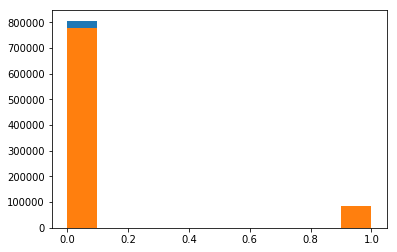

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
print("predicting_test_sample")
dff = pd.read_csv('input_data/test_sampling5.csv')
print(dff.head())
dff, yy = clear_data(dff,'train')
dff = dff.drop(columns=['Unnamed: 0'])
output = model.predict(dff,batch_size=batch_size,verbose=2)


predicting_test_sample
   Unnamed: 0     ip  app  device  os  channel           click_time  \
0   178450426  63051   26       1  19      266  2017-11-09 14:00:13   
1   160852079  49602   26       2  19      266  2017-11-09 08:36:15   
2   118079796  25648    2       1   6      477  2017-11-08 14:49:12   
3   162379166   2965    8       1  19      140  2017-11-09 09:08:20   
4    84248176  20578   18       1  10      134  2017-11-08 04:33:53   

  attributed_time  is_attributed  
0             NaN              0  
1             NaN              0  
2             NaN              0  
3             NaN              0  
4             NaN              0  


[ 0.03002905  0.03003944  0.01955846 ...,  0.01876744  0.02036615
  0.01845607]
(18490389,)


(array([ 18445120.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,     45269.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

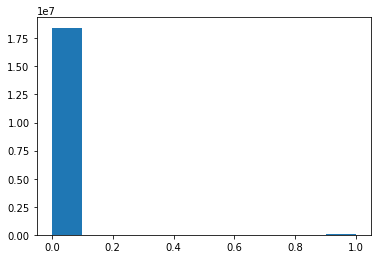

In [10]:
print(np.reshape(output,18490389))
print(yy.shape)
# dd = np.array([np.reshape(output,18490389),yy.values])

plt.hist(yy)



(array([  1.80737100e+07,   4.46080000e+04,   1.24060000e+04,
          4.74870000e+04,   1.49660000e+04,   6.25760000e+04,
          2.65860000e+04,   1.04700000e+05,   3.42370000e+04,
          6.91130000e+04]),
 array([  4.18383024e-05,   9.54300843e-02,   1.90818330e-01,
          2.86206576e-01,   3.81594822e-01,   4.76983068e-01,
          5.72371314e-01,   6.67759560e-01,   7.63147806e-01,
          8.58536052e-01,   9.53924298e-01]),
 <a list of 10 Patch objects>)

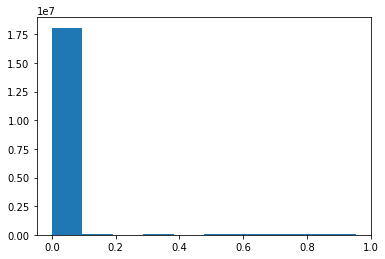

In [11]:
plt.hist(output)

In [12]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('input_data/kaggle_test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   4.452698e-02
std    5.424341e+06   1.228998e-01
min    0.000000e+00   2.031225e-03
25%    4.697617e+06   1.922510e-02
50%    9.395234e+06   2.034118e-02
75%    1.409285e+07   2.099149e-02
max    1.879047e+07   9.525525e-01


(array([ 18062169.,     59398.,     19774.,     62070.,     66129.,
            53299.,     58459.,    214927.,    104981.,     89263.]),
 array([ 0.00203122,  0.09708335,  0.19213548,  0.28718761,  0.38223973,
         0.47729186,  0.57234399,  0.66739612,  0.76244824,  0.85750037,
         0.9525525 ]),
 <a list of 10 Patch objects>)

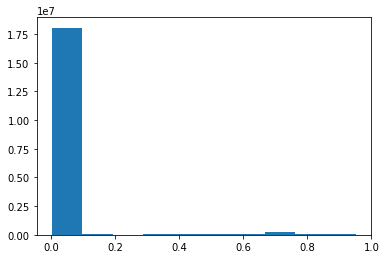

In [13]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [14]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample5.csv',index=False)




save the result


(array([ 18270101.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    520368.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

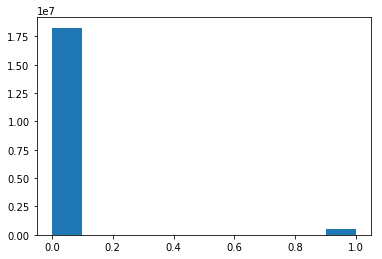

In [15]:
plt.hist(np.round(df_sub['is_attributed']))